In [6]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import ParameterGrid

warnings.filterwarnings(action='ignore')

In [4]:
df = pd.read_csv('특별자치구.csv', parse_dates=['YMD_CD'], index_col='Unnamed: 0')

In [7]:
df

,YMD_CD,SMCL_CD,PRST_NO,ITEM_CD,SALE_QTY,day_0,day_1,day_2,day_3,day_4,...,WEEKDAY,FRIDAY,HOLIDAY,SALE_QTY_lag1,SALE_QTY_lag2,SALE_QTY_lag3,SALE_QTY_lag4,SALE_QTY_lag5,SALE_QTY_lag6,SALE_QTY_lag7
800,2022-12-04,38,34984,76224935,0,0,0,0,0,0,...,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
801,2022-12-04,38,34984,80001249,0,0,0,0,0,0,...,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
802,2022-12-04,38,34984,80001263,0,0,0,0,0,0,...,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
803,2022-12-04,38,34984,80176732,0,0,0,0,0,0,...,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
804,2022-12-04,38,34984,80906032,0,0,0,0,0,0,...,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60995999,2024-04-04,135,221915,9310441005269,0,0,0,0,1,0,...,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60996000,2024-04-04,135,221915,9310441005290,0,0,0,0,1,0,...,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60996001,2024-04-04,135,221915,9329982020877,0,0,0,0,1,0,...,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60996002,2024-04-04,135,221915,9414453903794,0,0,0,0,1,0,...,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# PRST_NO와 ITEM_CD 별로 그룹화하여 SALE_QTY 합산
grouped_df = df.groupby(['PRST_NO', 'ITEM_CD'])['SALE_QTY'].sum().reset_index()

# 각 PRST_NO, ITEM_CD 별 SALE_QTY 합산값이 100개 이상인 경우 필터링
filtered_groups = grouped_df[grouped_df['SALE_QTY'] >= 500]

# 필터링된 그룹을 기준으로 원본 데이터 필터링
filtered_df = df.merge(filtered_groups[['PRST_NO', 'ITEM_CD']], on=['PRST_NO', 'ITEM_CD'], how='inner')

In [22]:
# 필터링 전 6944 -> 1573
print(grouped_df.shape[0])
print(filtered_groups.shape[0])

6944
178


## ts런 설치

In [8]:
!pip install tslearn

  Obtaining dependency information for tslearn from https://files.pythonhosted.org/packages/97/22/8dba9a7149d51fe0b6163a5a6b7efc315ab3c097cb6b0d1fc649a03f2722/tslearn-0.6.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 10.4 MB/s eta 0:00:0000:01


In [9]:
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt

In [19]:
pd.set_option('display.max_columns', None)

In [23]:
filtered_df

,YMD_CD,SMCL_CD,PRST_NO,ITEM_CD,SALE_QTY,day_0,day_1,day_2,day_3,day_4,day_5,day_6,WEEKDAY,FRIDAY,HOLIDAY,SALE_QTY_lag1,SALE_QTY_lag2,SALE_QTY_lag3,SALE_QTY_lag4,SALE_QTY_lag5,SALE_QTY_lag6,SALE_QTY_lag7
0,2022-12-04,122,34984,8801056018979,2,0,0,0,0,0,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-12-05,122,34984,8801056018979,6,1,0,0,0,0,0,0,1,0,0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-12-06,122,34984,8801056018979,4,0,1,0,0,0,0,0,1,0,0,6.0,2.0,NaN,NaN,NaN,NaN,NaN
3,2022-12-07,122,34984,8801056018979,5,0,0,1,0,0,0,0,1,0,0,4.0,6.0,2.0,NaN,NaN,NaN,NaN
4,2022-12-08,122,34984,8801056018979,4,0,0,0,1,0,0,0,1,0,0,5.0,4.0,6.0,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86859,2024-03-31,135,221915,8712000900045,0,0,0,0,0,0,0,1,0,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
86860,2024-04-01,135,221915,8712000900045,0,1,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
86861,2024-04-02,135,221915,8712000900045,0,0,1,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
86862,2024-04-03,135,221915,8712000900045,0,0,0,1,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", verbose=True, random_state=0)
y_pred = model.fit_predict(series)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.7s


1431.163 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.9s


1135.071 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.9s


1123.378 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.0s


1121.670 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.9s


1121.670 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.9s


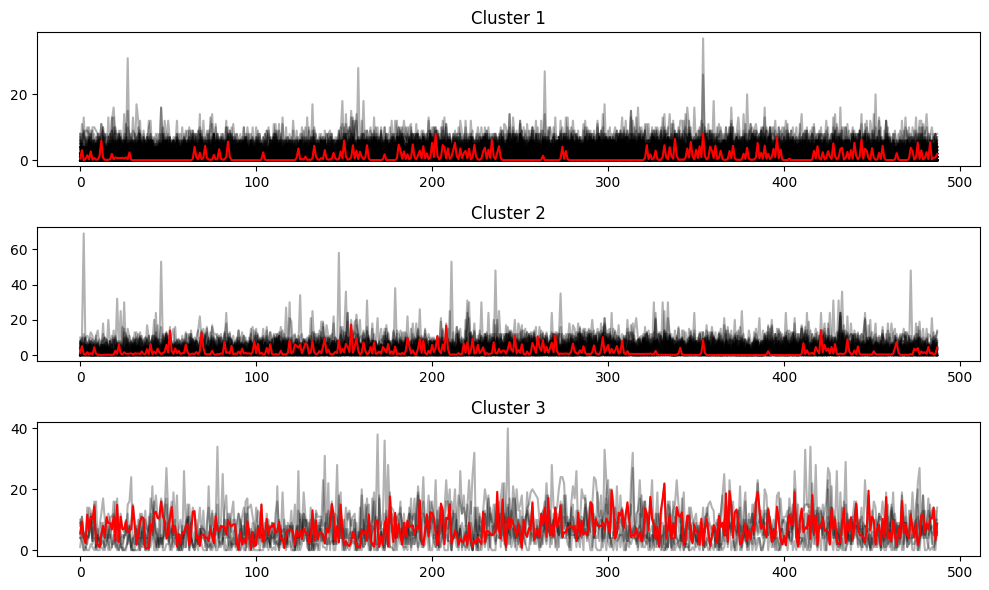

In [25]:
# 필요한 열만 선택
df = filtered_df[['YMD_CD', 'SALE_QTY', 'PRST_NO', 'ITEM_CD', 'SMCL_CD']]

# 데이터프레임을 시계열 형식으로 변환
# 각 PRST_NO, ITEM_CD 별로 그룹화하고, 날짜별 SALE_QTY를 시계열로 정렬
grouped = df.groupby(['PRST_NO', 'ITEM_CD', 'YMD_CD']).sum().unstack().fillna(0)

# 시계열 데이터를 numpy 배열로 변환
# tslearn의 K-means 클러스터링은 3차원 배열을 필요로 함
time_series_data = grouped['SALE_QTY'].values
time_series_data = time_series_data.reshape((time_series_data.shape[0], time_series_data.shape[1], 1))

# K-means 클러스터링 수행
n_clusters = 3  # 클러스터 개수
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=True, random_state=0)
y_pred = model.fit_predict(time_series_data)

# 클러스터링 결과 시각화
plt.figure(figsize=(10, 6))
for cluster_num in range(n_clusters):
    plt.subplot(n_clusters, 1, cluster_num + 1)
    for ts in time_series_data[y_pred == cluster_num]:
        plt.plot(ts.ravel(), "k-", alpha=0.3)
    plt.plot(model.cluster_centers_[cluster_num].ravel(), "r-")
    plt.title(f"Cluster {cluster_num + 1}")

plt.tight_layout()
plt.show()

# 클러스터링 결과를 데이터프레임에 추가
grouped['Cluster'] = y_pred

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.8s


1431.163 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.9s


1135.071 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.9s


1123.378 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.9s


1121.670 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.9s


1121.670 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.9s


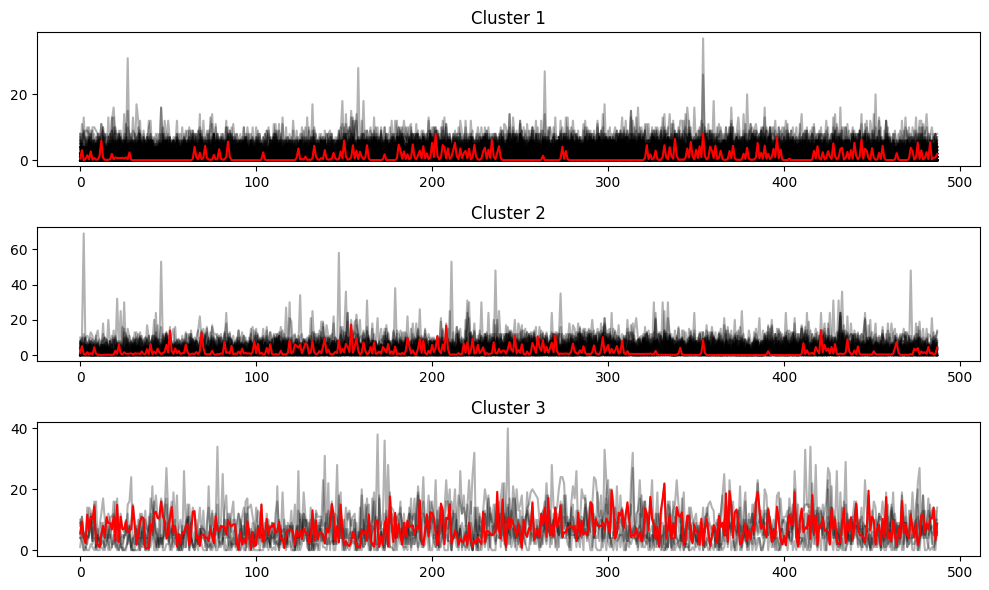

In [26]:
# 날짜별로 정렬
df = df.sort_values(by='YMD_CD')

# 데이터를 PRST_NO와 ITEM_CD별로 그룹화하고, 날짜별 SALE_QTY를 시계열로 정렬
grouped = df.groupby(['PRST_NO', 'ITEM_CD', 'YMD_CD']).sum().unstack().fillna(0)

# 시계열 데이터를 numpy 배열로 변환
# tslearn의 K-means 클러스터링은 3차원 배열을 필요로 함
time_series_data = grouped['SALE_QTY'].values
time_series_data = time_series_data.reshape((time_series_data.shape[0], time_series_data.shape[1], 1))

# K-means 클러스터링 수행
n_clusters = 3  # 클러스터 개수
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=True, random_state=0)
y_pred = model.fit_predict(time_series_data)

# 클러스터링 결과 시각화
plt.figure(figsize=(10, 6))
for cluster_num in range(n_clusters):
    plt.subplot(n_clusters, 1, cluster_num + 1)
    for ts in time_series_data[y_pred == cluster_num]:
        plt.plot(ts.ravel(), "k-", alpha=0.3)
    plt.plot(model.cluster_centers_[cluster_num].ravel(), "r-")
    plt.title(f"Cluster {cluster_num + 1}")

plt.tight_layout()
plt.show()

# 클러스터링 결과를 데이터프레임에 추가
grouped['Cluster'] = y_pred

In [27]:
grouped['Cluster']

YMD_CD                 NaT
PRST_NO ITEM_CD           
34984   50213085         0
        88002798         1
        4066600601920    1
        4901004006813    1
        4901004057044    1
...                    ...
221915  8801104221467    0
        8801115134213    0
        8801119740113    1
        8801858011017    1
        8801858011024    2

[178 rows x 1 columns]

In [30]:
store_mst = pd.read_csv('STORE_MST.txt', sep='|', encoding='cp949')

In [31]:
store_mst

,PRST_NO,STOR_NM,LCTN_TY_CD,LCTN_TY_NM,GUBUN,GUBUN_NM,OPRT_TIME_DIV_CD,STOR_SIZE_CD
0,70463,장기파랑새점,8,주경야유,2,02.광역시,1,2
1,151131,삼산타운점,8,주경야유,2,02.광역시,1,1
2,942435,서면점,8,주경야유,2,02.광역시,1,6
3,50055,영동중앙점,6,유흥가,3,03.충청도,1,6
4,90299,뉴진천점,6,유흥가,3,03.충청도,1,2
...,...,...,...,...,...,...,...,...
139,50261,천안로얄점,7,주택근생,3,03.충청도,1,6
140,70233,동탄광장점,6,유흥가,1,01.서울/경기,1,2
141,60184,전주서신3호점,4,오피스가,4,04.전라도,1,3
142,180948,남해북변터미널점,7,주택근생,5,05.경상도,1,3


In [36]:
df

,YMD_CD,SALE_QTY,PRST_NO
0,2022-12-04,2,34984
75152,2022-12-04,0,34984
20008,2022-12-04,0,34984
19520,2022-12-04,1,221915
75640,2022-12-04,8,34984
...,...,...,...
56119,2024-04-04,1,221915
55631,2024-04-04,13,221915
55143,2024-04-04,2,221522
42943,2024-04-04,1,221522


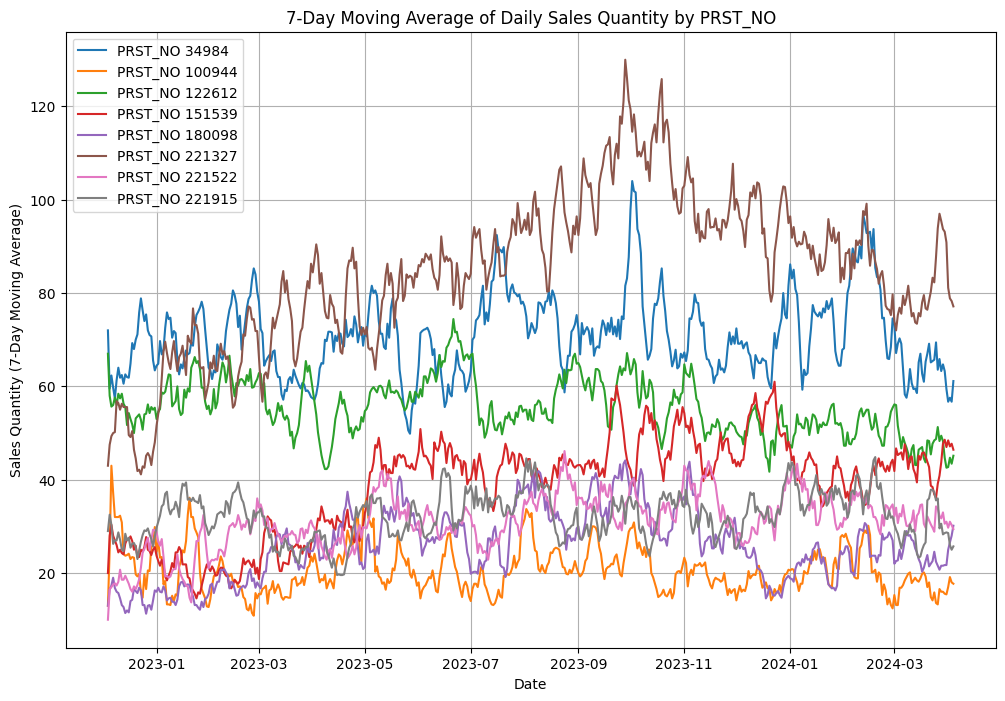

In [29]:
# 필요한 열만 선택
df = df[['YMD_CD', 'SALE_QTY', 'PRST_NO']]

# PRST_NO별로 일단위 판매량 계산
daily_sales = df.groupby(['PRST_NO', 'YMD_CD'])['SALE_QTY'].sum().reset_index()

# 7일 이동 평균 계산
daily_sales['Moving_Avg'] = daily_sales.groupby('PRST_NO')['SALE_QTY'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

# PRST_NO별로 7일 이동 평균 판매량 패턴을 플롯
unique_prst_no = daily_sales['PRST_NO'].unique()

plt.figure(figsize=(12, 8))

for prst_no in unique_prst_no:
    prst_data = daily_sales[daily_sales['PRST_NO'] == prst_no]
    plt.plot(prst_data['YMD_CD'], prst_data['Moving_Avg'], label=f'PRST_NO {prst_no}')

plt.title('7-Day Moving Average of Daily Sales Quantity by PRST_NO')
plt.xlabel('Date')
plt.ylabel('Sales Quantity (7-Day Moving Average)')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.rcParams['axes.unicode_minus'] = False

matplotlib.rcParams['font.family'] = "AppleGothic"

In [ ]:
# store_mst 데이터프레임에서 필요한 열만 선택
store_mst_subset = store_mst[['PRST_NO', 'STOR_NM', 'GUBUN_NM', 'LCTN_TY_NM']]

# df와 store_mst_subset 데이터프레임 병합
merged_df = pd.merge(df, store_mst_subset, on='PRST_NO', how='left')

In [37]:
merged_df

,YMD_CD,SALE_QTY,PRST_NO,STOR_NM,GUBUN_NM,LCTN_TY_NM
0,2022-12-04,2,34984,제주서해점,06.특별자치,유흥가
1,2022-12-04,0,34984,제주서해점,06.특별자치,유흥가
2,2022-12-04,0,34984,제주서해점,06.특별자치,유흥가
3,2022-12-04,1,221915,서귀포프리미엄점,06.특별자치,주경야유
4,2022-12-04,8,34984,제주서해점,06.특별자치,유흥가
...,...,...,...,...,...,...
86859,2024-04-04,1,221915,서귀포프리미엄점,06.특별자치,주경야유
86860,2024-04-04,13,221915,서귀포프리미엄점,06.특별자치,주경야유
86861,2024-04-04,2,221522,세종한뜰마을4단지점,06.특별자치,가족주택
86862,2024-04-04,1,221522,세종한뜰마을4단지점,06.특별자치,가족주택


In [40]:
# 컬러 맵 생성
unique_locations = merged_df['LCTN_TY_NM'].unique()
colors = sns.color_palette("husl", len(unique_locations))
color_map = dict(zip(unique_locations, colors))

In [43]:
color_map

{'유흥가': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 '주경야유': (0.8087954113106306, 0.5634700050056693, 0.19502642696727285),
 '독신자주택': (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 '로드사이드': (0.19783576093349015, 0.6955516966063037, 0.3995301037444499),
 '주택근생': (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 '가족주택': (0.22335772267769388, 0.6565792317435265, 0.8171355503265633),
 '오피스가': (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 '산업지대': (0.9603888539940703, 0.3814317878772117, 0.8683117650835491)}

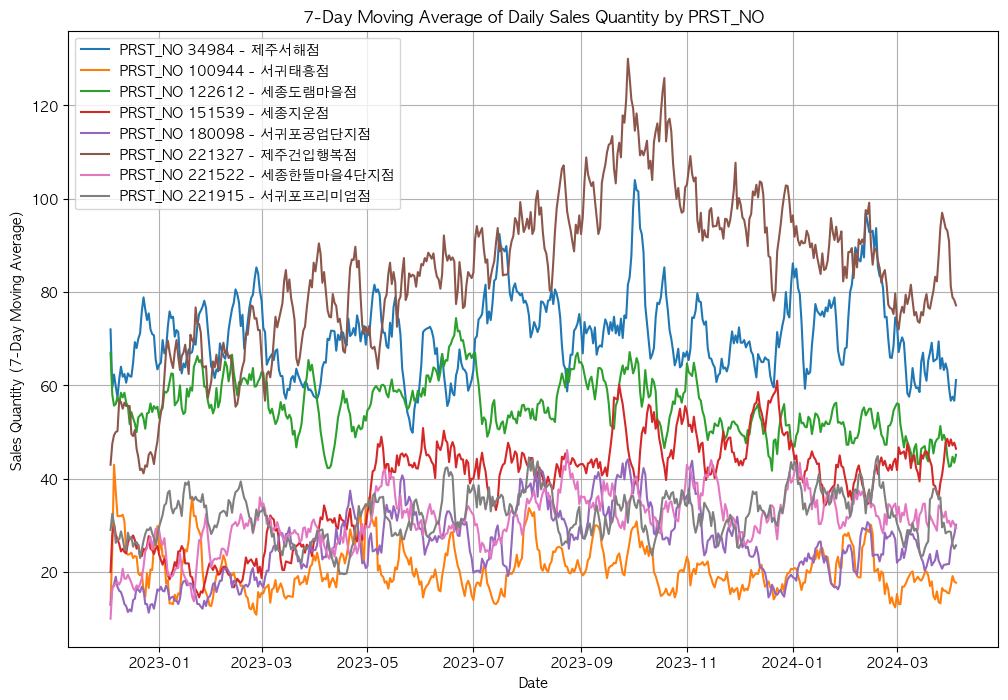

In [41]:
# PRST_NO별로 일단위 판매량 계산
daily_sales = merged_df.groupby(['PRST_NO', 'YMD_CD'])['SALE_QTY'].sum().reset_index()

# 7일 이동 평균 계산
daily_sales['Moving_Avg'] = daily_sales.groupby('PRST_NO')['SALE_QTY'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

# 병합된 데이터프레임과 이동 평균을 포함한 데이터프레임 병합
final_df = pd.merge(daily_sales, store_mst_subset, on='PRST_NO', how='left')

# PRST_NO별로 7일 이동 평균 판매량 패턴을 플롯
unique_prst_no = final_df['PRST_NO'].unique()

plt.figure(figsize=(12, 8))

for prst_no in unique_prst_no:
    prst_data = final_df[final_df['PRST_NO'] == prst_no]
    plt.plot(prst_data['YMD_CD'], prst_data['Moving_Avg'], label=f'PRST_NO {prst_no} - {prst_data["STOR_NM"].iloc[0]}')

plt.title('7-Day Moving Average of Daily Sales Quantity by PRST_NO')
plt.xlabel('Date')
plt.ylabel('Sales Quantity (7-Day Moving Average)')
plt.legend()
plt.grid(True)
plt.show()


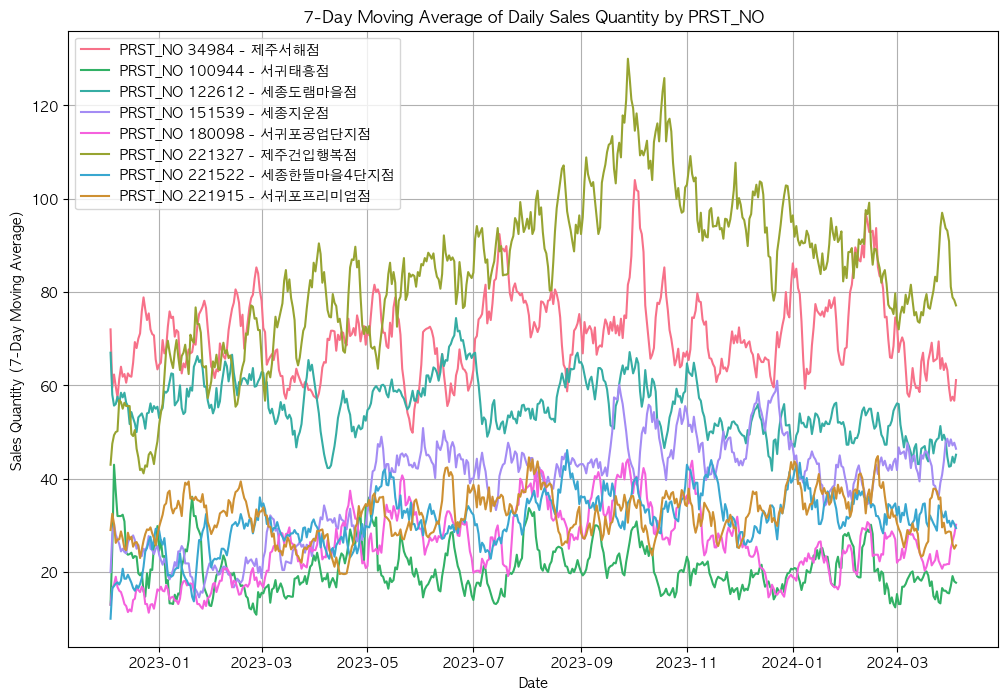

In [42]:
# PRST_NO별로 7일 이동 평균 판매량 패턴을 플롯
unique_prst_no = final_df['PRST_NO'].unique()

plt.figure(figsize=(12, 8))

for prst_no in unique_prst_no:
    prst_data = final_df[final_df['PRST_NO'] == prst_no]
    location_type = prst_data['LCTN_TY_NM'].iloc[0]
    color = color_map[location_type]
    plt.plot(prst_data['YMD_CD'], prst_data['Moving_Avg'], label=f'PRST_NO {prst_no} - {prst_data["STOR_NM"].iloc[0]}', color=color)

plt.title('7-Day Moving Average of Daily Sales Quantity by PRST_NO')
plt.xlabel('Date')
plt.ylabel('Sales Quantity (7-Day Moving Average)')
plt.legend()
plt.grid(True)
plt.show()

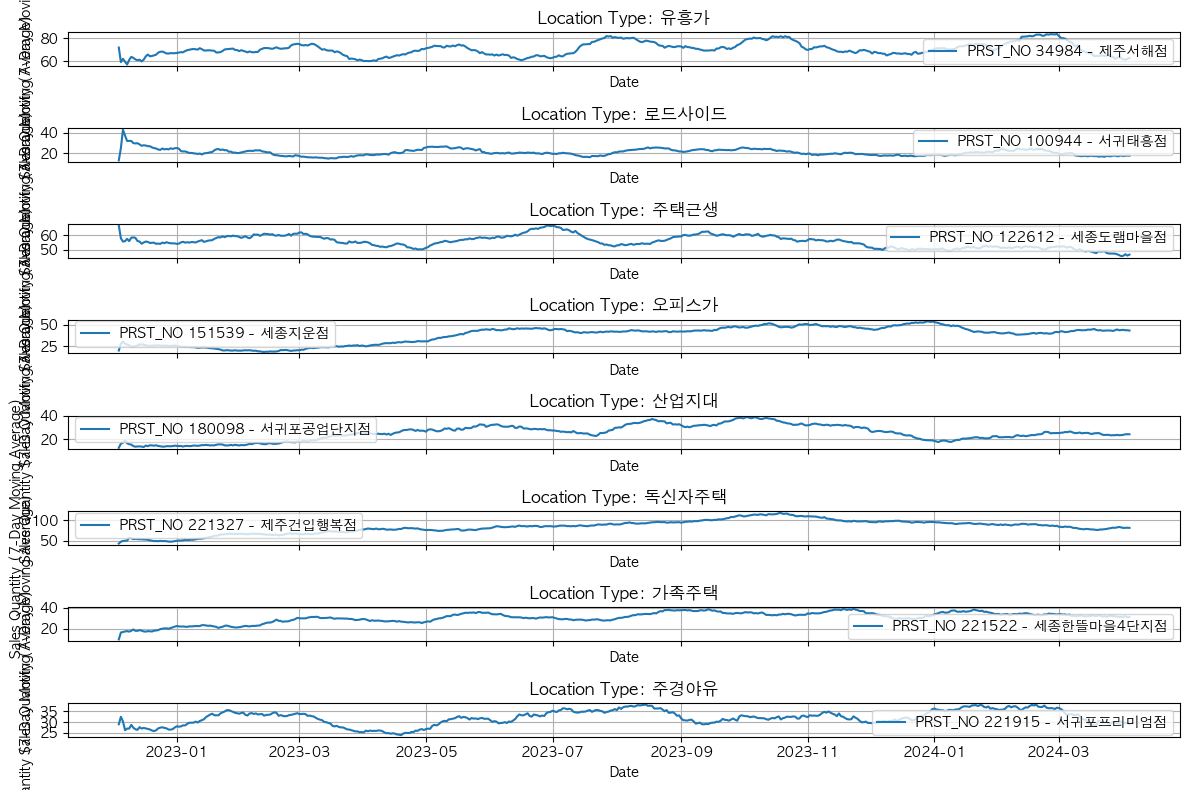

In [62]:
# store_mst 데이터프레임에서 필요한 열만 선택
store_mst_subset = store_mst[['PRST_NO', 'STOR_NM', 'GUBUN_NM', 'LCTN_TY_NM']]

# df와 store_mst_subset 데이터프레임 병합
merged_df = pd.merge(df, store_mst_subset, on='PRST_NO', how='left')

# PRST_NO별로 일단위 판매량 계산
daily_sales = merged_df.groupby(['PRST_NO', 'YMD_CD'])['SALE_QTY'].sum().reset_index()

# 7일 이동 평균 계산
daily_sales['Moving_Avg'] = daily_sales.groupby('PRST_NO')['SALE_QTY'].transform(lambda x: x.rolling(window=28, min_periods=1).mean())

# 병합된 데이터프레임과 이동 평균을 포함한 데이터프레임 병합
final_df = pd.merge(daily_sales, store_mst_subset, on='PRST_NO', how='left')

# 컬러 맵 생성
unique_locations = final_df['LCTN_TY_NM'].unique()
colors = sns.color_palette("husl", len(unique_locations))
color_map = dict(zip(unique_locations, colors))

# LCTN_TY_NM별로 그룹화
unique_lctn_ty_nm = final_df['LCTN_TY_NM'].unique()

fig, axes = plt.subplots(len(unique_lctn_ty_nm), 1, figsize=(12, 8), sharex=True)

for ax, lctn_ty_nm in zip(axes, unique_lctn_ty_nm):
    location_data = final_df[final_df['LCTN_TY_NM'] == lctn_ty_nm]
    unique_prst_no = location_data['PRST_NO'].unique()
    for prst_no in unique_prst_no:
        prst_data = location_data[location_data['PRST_NO'] == prst_no]
        ax.plot(prst_data['YMD_CD'], prst_data['Moving_Avg'], label=f'PRST_NO {prst_no} - {prst_data["STOR_NM"].iloc[0]}')
    ax.set_title(f'Location Type: {lctn_ty_nm}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales Quantity (7-Day Moving Average)')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

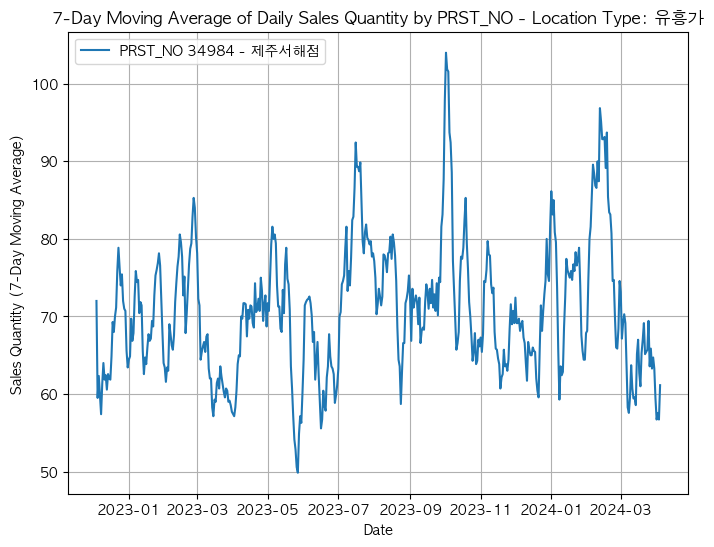

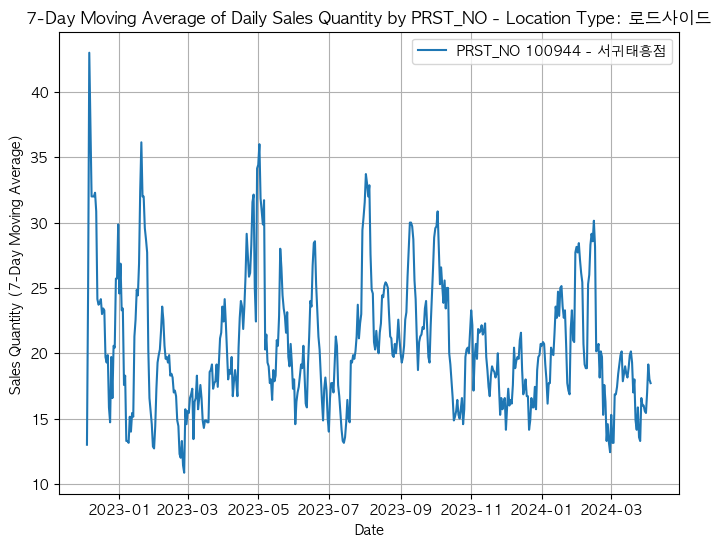

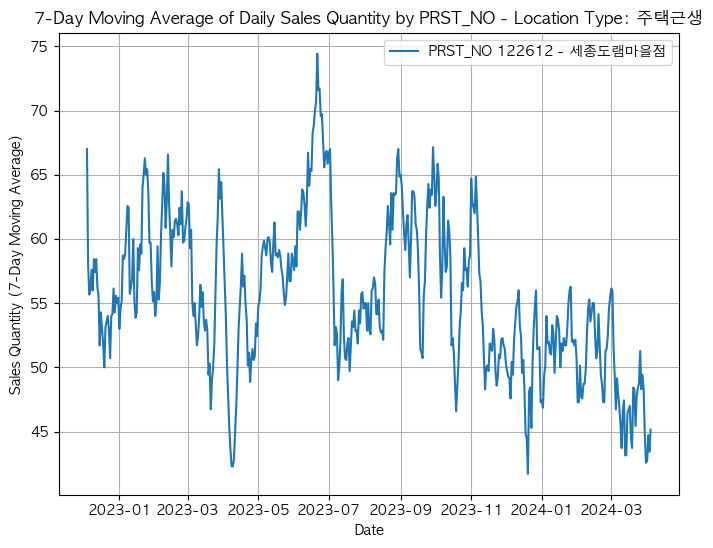

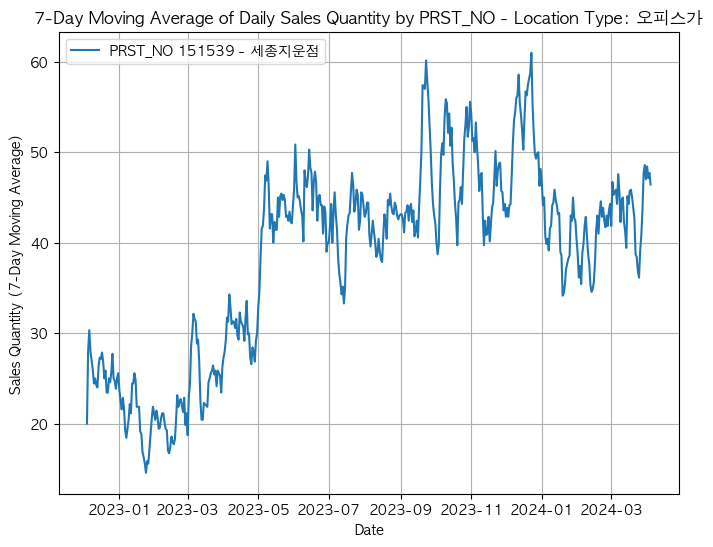

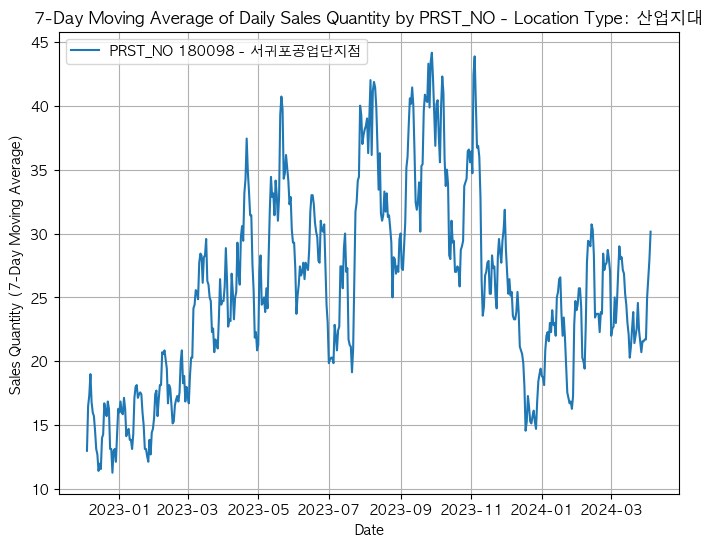

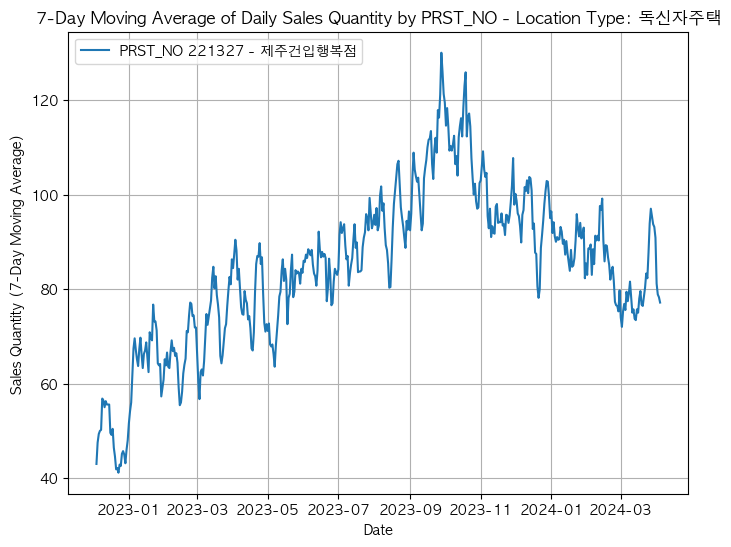

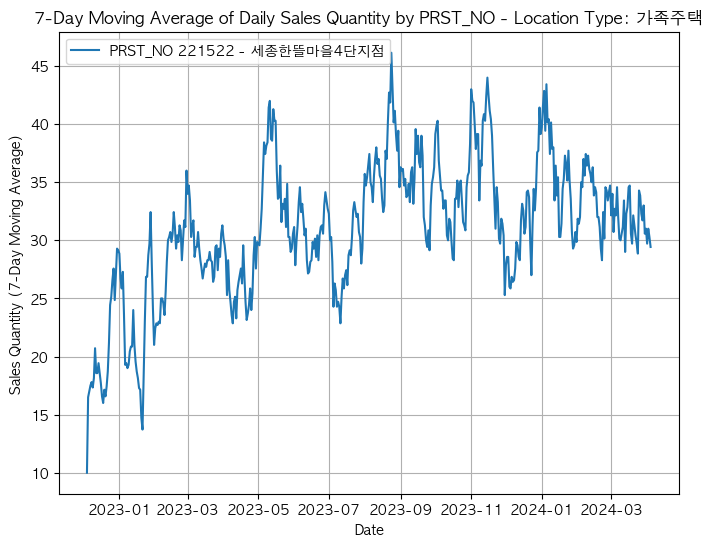

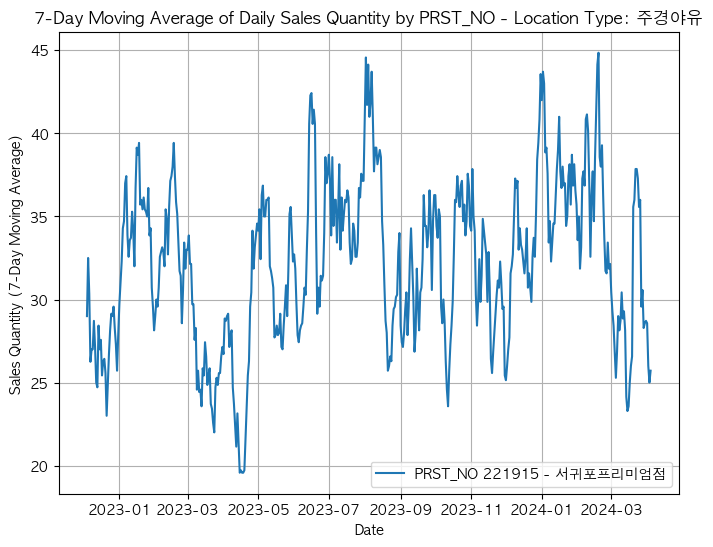

In [46]:
# LCTN_TY_NM별로 그룹화
unique_lctn_ty_nm = final_df['LCTN_TY_NM'].unique()

# 각 location_type 별로 개별 플롯 생성
for lctn_ty_nm in unique_lctn_ty_nm:
    plt.figure(figsize=(8, 6))
    location_data = final_df[final_df['LCTN_TY_NM'] == lctn_ty_nm]
    unique_prst_no = location_data['PRST_NO'].unique()
    for prst_no in unique_prst_no:
        prst_data = location_data[location_data['PRST_NO'] == prst_no]
        plt.plot(prst_data['YMD_CD'], prst_data['Moving_Avg'], label=f'PRST_NO {prst_no} - {prst_data["STOR_NM"].iloc[0]}')
    plt.title(f'7-Day Moving Average of Daily Sales Quantity by PRST_NO - Location Type: {lctn_ty_nm}')
    plt.xlabel('Date')
    plt.ylabel('Sales Quantity (7-Day Moving Average)')
    plt.legend()
    plt.grid(True)
    plt.show()

16067.555 --> 3128.828 --> 3128.828 --> 


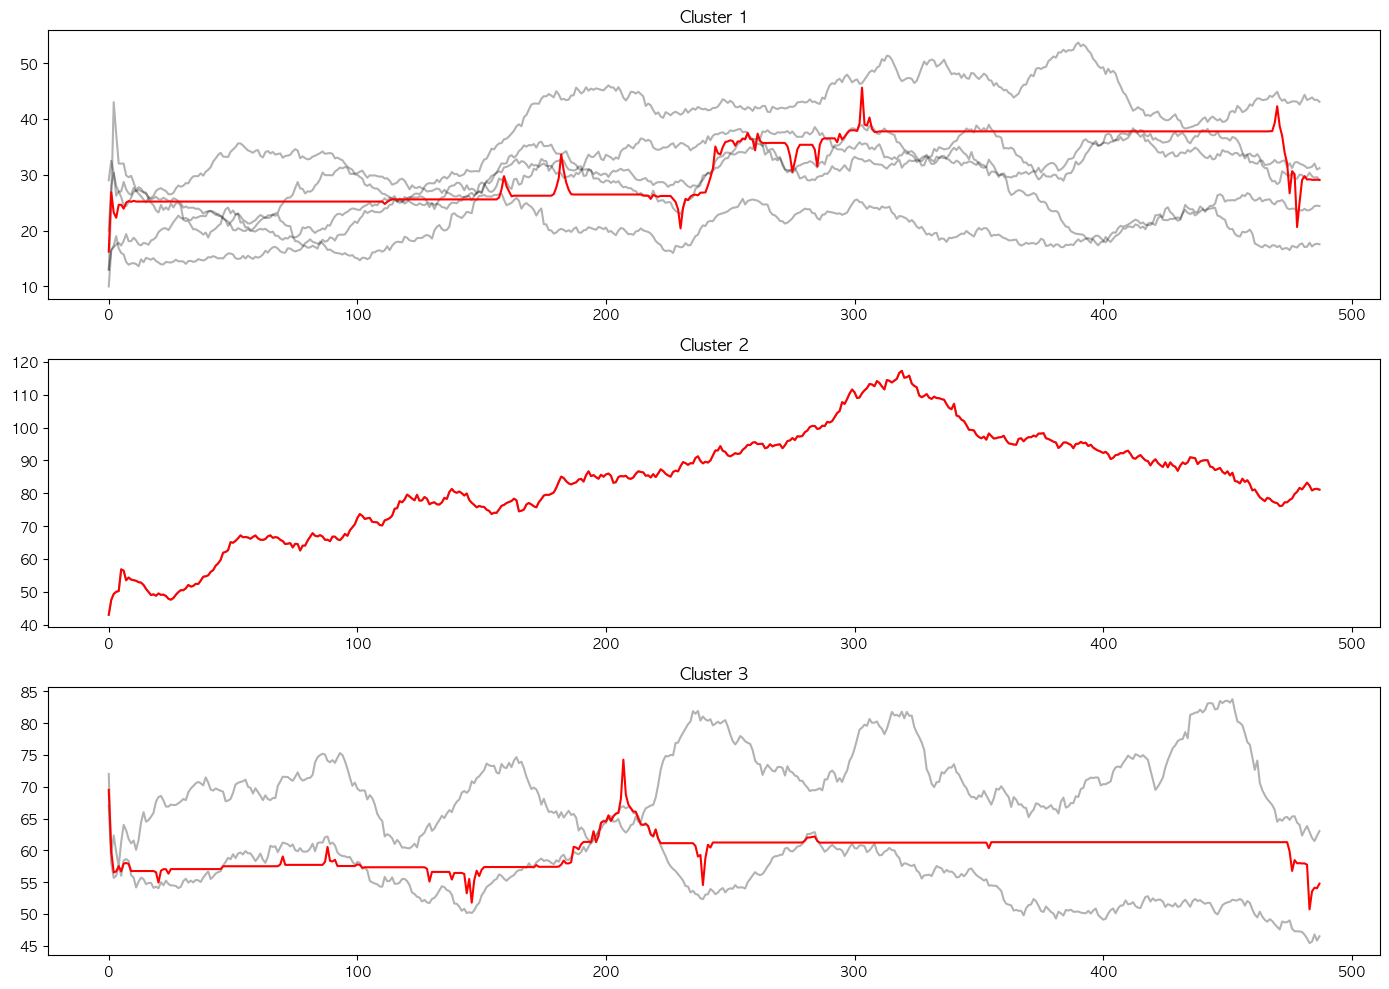

In [63]:
# 시계열 데이터를 numpy 배열로 변환 (tslearn의 K-means 클러스터링은 3차원 배열을 필요로 함)
time_series_data = []
unique_prst_no = final_df['PRST_NO'].unique()

for prst_no in unique_prst_no:
    prst_data = final_df[final_df['PRST_NO'] == prst_no]
    prst_data = prst_data.sort_values('YMD_CD')
    time_series_data.append(prst_data['Moving_Avg'].values)

time_series_data = np.array(time_series_data)
time_series_data = time_series_data.reshape((time_series_data.shape[0], time_series_data.shape[1], 1))

# K-means 클러스터링 수행
n_clusters = 3  # 클러스터 개수
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=True, random_state=0)
y_pred = model.fit_predict(time_series_data)

# 클러스터링 결과를 데이터프레임에 추가
cluster_df = pd.DataFrame({'PRST_NO': unique_prst_no, 'Cluster': y_pred})
final_df = pd.merge(final_df, cluster_df, on='PRST_NO')

# 클러스터링 결과 시각화
plt.figure(figsize=(14, 10))
for cluster_num in range(n_clusters):
    plt.subplot(n_clusters, 1, cluster_num + 1)
    for ts in time_series_data[y_pred == cluster_num]:
        plt.plot(ts.ravel(), "k-", alpha=0.3)
    plt.plot(model.cluster_centers_[cluster_num].ravel(), "r-")
    plt.title(f"Cluster {cluster_num + 1}")

plt.tight_layout()
plt.show()

In [48]:
final_df

,PRST_NO,YMD_CD,SALE_QTY,Moving_Avg,STOR_NM,GUBUN_NM,LCTN_TY_NM,Cluster
0,34984,2022-12-04,72,72.000000,제주서해점,06.특별자치,유흥가,1
1,34984,2022-12-05,47,59.500000,제주서해점,06.특별자치,유흥가,1
2,34984,2022-12-06,68,62.333333,제주서해점,06.특별자치,유흥가,1
3,34984,2022-12-07,52,59.750000,제주서해점,06.특별자치,유흥가,1
4,34984,2022-12-08,48,57.400000,제주서해점,06.특별자치,유흥가,1
...,...,...,...,...,...,...,...,...
3899,221915,2024-03-31,37,28.714286,서귀포프리미엄점,06.특별자치,주경야유,0
3900,221915,2024-04-01,12,28.571429,서귀포프리미엄점,06.특별자치,주경야유,0
3901,221915,2024-04-02,8,26.000000,서귀포프리미엄점,06.특별자치,주경야유,0
3902,221915,2024-04-03,33,25.000000,서귀포프리미엄점,06.특별자치,주경야유,0


In [51]:
df

,YMD_CD,SALE_QTY,PRST_NO
0,2022-12-04,2,34984
75152,2022-12-04,0,34984
20008,2022-12-04,0,34984
19520,2022-12-04,1,221915
75640,2022-12-04,8,34984
...,...,...,...
56119,2024-04-04,1,221915
55631,2024-04-04,13,221915
55143,2024-04-04,2,221522
42943,2024-04-04,1,221522


In [55]:
check = store_mst[['PRST_NO', 'LCTN_TY_NM', 'STOR_NM']]

In [56]:
cluster_df = pd.merge(cluster_df, check, on='PRST_NO')

In [57]:
cluster_df

,PRST_NO,Cluster,LCTN_TY_NM_x,LCTN_TY_NM_y,STOR_NM
0,34984,1,유흥가,유흥가,제주서해점
1,100944,0,로드사이드,로드사이드,서귀태흥점
2,122612,2,주택근생,주택근생,세종도램마을점
3,151539,0,오피스가,오피스가,세종지운점
4,180098,0,산업지대,산업지대,서귀포공업단지점
5,221327,1,독신자주택,독신자주택,제주건입행복점
6,221522,0,가족주택,가족주택,세종한뜰마을4단지점
7,221915,0,주경야유,주경야유,서귀포프리미엄점


In [91]:
train = pd.read_csv('SALE_ITEM_221204_240104.csv', sep='|', parse_dates=['YMD_CD'])
test = pd.read_csv('SALE_ITEM_231204_240404.csv', sep='|', parse_dates=['YMD_CD'])
item_mst = pd.read_csv('ITEM_MST.txt', sep='|', encoding='cp949')

In [82]:
store_mst

,PRST_NO,STOR_NM,LCTN_TY_CD,LCTN_TY_NM,GUBUN,GUBUN_NM,OPRT_TIME_DIV_CD,STOR_SIZE_CD
0,70463,장기파랑새점,8,주경야유,2,02.광역시,1,2
1,151131,삼산타운점,8,주경야유,2,02.광역시,1,1
2,942435,서면점,8,주경야유,2,02.광역시,1,6
3,50055,영동중앙점,6,유흥가,3,03.충청도,1,6
4,90299,뉴진천점,6,유흥가,3,03.충청도,1,2
...,...,...,...,...,...,...,...,...
139,50261,천안로얄점,7,주택근생,3,03.충청도,1,6
140,70233,동탄광장점,6,유흥가,1,01.서울/경기,1,2
141,60184,전주서신3호점,4,오피스가,4,04.전라도,1,3
142,180948,남해북변터미널점,7,주택근생,5,05.경상도,1,3


In [66]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import AgglomerativeClustering
from tslearn.metrics import cdist_dtw

In [92]:
temp_item_subset = item_mst[['ITEM_CD', 'ITEM_NM', 'HYUN_MAEGA']]
temp_store_subset = store_mst[['PRST_NO', 'STOR_NM', 'LCTN_TY_CD', 'LCTN_TY_NM', 'GUBUN_NM']]

In [101]:
# train = pd.merge(train, temp_item_subset, on='ITEM_CD', how='left')
test= pd.merge(test, temp_item_subset, on='ITEM_CD', how='left')

In [102]:
# train = pd.merge(train, temp_store_subset, on='PRST_NO', how='left')
test = pd.merge(test, temp_store_subset, on='PRST_NO', how='left')

In [103]:
# train['MAECHUL'] = train['HYUN_MAEGA'] * train['SALE_QTY']
test['MAECHUL'] = test['HYUN_MAEGA'] * train['SALE_QTY']

In [ ]:
# test.info()
# train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15374036 entries, 0 to 15374035
Data columns (total 12 columns):
 #   Column      Dtype         
---  ------      -----         
 0   YMD_CD      datetime64[ns]
 1   PRST_NO     int64         
 2   SMCL_CD     int64         
 3   ITEM_CD     int64         
 4   SALE_QTY    int64         
 5   ITEM_NM     object        
 6   HYUN_MAEGA  float64       
 7   STOR_NM     object        
 8   LCTN_TY_CD  int64         
 9   LCTN_TY_NM  object        
 10  GUBUN_NM    object        
 11  MAECHUL     float64       
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 1.4+ GB


In [97]:
train['MAECHUL']

0           30600.0
1           15000.0
2           25200.0
3           19500.0
4           15600.0
             ...   
49621855        0.0
49621856        0.0
49621857        0.0
49621858        0.0
49621859        0.0
Name: MAECHUL, Length: 49621860, dtype: float64

In [105]:
# 요일 정보를 새로운 컬럼에 추가
# train['days'] = train['YMD_CD'].dt.day_name()
test['days'] = test['YMD_CD'].dt.day_name()

In [100]:
train.to_csv('base_data_train.csv')

In [106]:
test.to_csv('base_data_test.csv')